In [1]:
import os
import glob
import lsst.eotest.image_utils as imutils
import lsst.eotest.sensor as sensorTest
import lsst.eotest.raft as raft
import matplotlib.pyplot as plt
import numpy as np
import yaml

In [2]:
import sys
sys.path.insert(0, '../')
import ccob_utils as u



In [3]:
config = u.load_ccob_config('/home/combet/ccob-wb/ccob_config_RTM-006.yaml')
led_names = ['uv', 'blue', 'red', 'nm750','nm850','nm960']
acq_log={}
for led in led_names:
    acq_log[led] = os.path.join(config['path'],led+'/ccob_acquisition.log')
acq_log  

{'blue': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/blue/ccob_acquisition.log',
 'nm750': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm750/ccob_acquisition.log',
 'nm850': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm850/ccob_acquisition.log',
 'nm960': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm960/ccob_acquisition.log',
 'red': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/red/ccob_acquisition.log',
 'uv': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/uv/ccob_acquisition.log'}

In [4]:
config

{'current': '*',
 'eo_data_path': '/gpfs/slac/lsst/fs1/g/data/jobHarness/jh_archive-test/LCA-11021_RTM/LCA-11021_RTM-006-Dev/5867D/collect_raft_results/v0/38904',
 'exp_time': '*',
 'led_name': 'red',
 'path': '/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob',
 'slot': '*',
 'tmp_dir': '/home/combet/tmp_new/',
 'xpos': '*',
 'ypos': '*'}

In [5]:
config['led_name'] = 'nm750'
config['path'] = os.path.join(config['path'],config['led_name'])


In [6]:
slot='11'
flist = sorted(u.find_files(config, slot=slot))

/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm750/11*nm750*********


In [7]:
f = flist[30]

In [8]:
mean_bias_file = slot+'_mean_bias_image_RTM-006.fits'
ccd_dict = sensorTest.MaskedCCD(f, bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))

eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(ccd_dict.md('LSST_NUM')))
gains_dict = u.gains(eotest_results_file)

In [9]:
gains_dict

{1: 0.71524864,
 2: 0.71960616,
 3: 0.71498865,
 4: 0.71638036,
 5: 0.71864289,
 6: 0.71314824,
 7: 0.71987009,
 8: 0.71678782,
 9: 0.70387024,
 10: 0.70772272,
 11: 0.7077561,
 12: 0.70162439,
 13: 0.70267493,
 14: 0.7020154,
 15: 0.70233214,
 16: 0.69480103}

In [10]:
amp = 4
image = ccd_dict.unbiased_and_trimmed_image(amp)
image *= gains_dict[amp]

In [11]:
arr = image.getArrays()

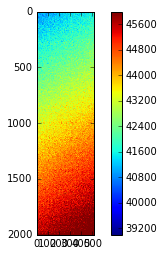

In [12]:
plt.imshow(arr[0], vmin=39000, vmax=46000)
plt.colorbar()

In [13]:
mean_bias_file = slot+'_mean_bias_image_RTM-006.fits'
eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(ccd_dict.md('LSST_NUM')))
gains_dict = u.gains(eotest_results_file)
nodes = {}
nodes['xarr'] = []
nodes['yarr'] = []
nodes['val'] = []
for i,f in enumerate(sorted(flist)):
    nodes['xarr'].append(float(os.path.basename(f).split('_')[3].split('x')[1]))
    nodes['yarr'].append(float(os.path.basename(f).split('_')[4].split('y')[1]))
    ccd_dict = sensorTest.MaskedCCD(f, bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
    amp = 4
    image = ccd_dict.unbiased_and_trimmed_image(amp)
    image *= gains_dict[amp]
    arr = image.getArrays()
    nodes['val'].append(np.mean((arr[0][1000:1000+30,256:256+30])))

In [84]:
np.unique(nodes['xarr'])

array([ 212.,  220.,  232.,  242.,  252.,  262.,  272.,  282.,  292.,
        302.,  312.,  322.,  332.,  342.,  352.,  362.])

In [14]:
from scipy import interpolate
f = interpolate.interp2d(np.unique(nodes['xarr']), np.unique(nodes['yarr']), nodes['val'], kind='cubic')

In [20]:
xarr2 = np.linspace(min(nodes['xarr']),max(nodes['xarr']),300)
yarr2 = np.linspace(min(nodes['yarr']),max(nodes['yarr']),300)
recons = f(xarr2, yarr2)
recons /= max(recons.flatten())


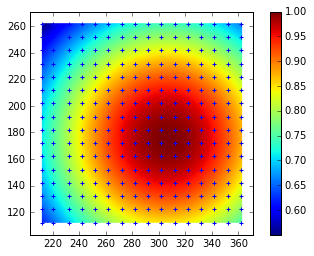

In [21]:
extent = [min(nodes['xarr']), max(nodes['xarr']),min(nodes['yarr']), max(nodes['yarr'])]
plt.imshow(recons, extent=extent)
plt.colorbar()
plt.scatter(nodes['xarr'],nodes['yarr'], marker='+', color='blue')

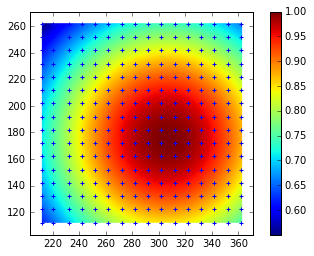

In [22]:
plt.imshow(recons/max(recons.flatten()), extent=extent)
plt.colorbar()
plt.scatter(nodes['xarr'],nodes['yarr'], marker='+', color='blue')

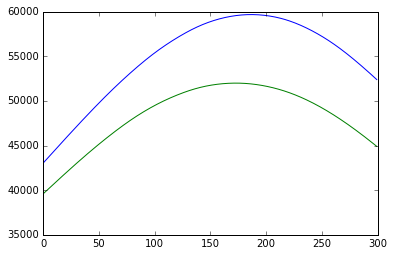

In [17]:
np.shape(recons)
plt.plot(recons[260,:])
plt.plot(recons[:,40])

In [30]:
def beam_recons(led_names, ref_slot='11', ref_amp=4, ref_pix_x=1000,
               ref_pix_y=256, npix_for_avg=30, npix_beam_image=300):


    mean_bias_file = ref_slot+'_mean_bias_image_RTM-006.fits'
    recons = {}

    for led in led_names:
        print(led)
        config = u.load_ccob_config('/home/combet/ccob-wb/ccob_config_RTM-006.yaml')
        config['led_name'] = led
        config['path'] = os.path.join(config['path'],config['led_name'])

        flist = sorted(u.find_files(config, slot=ref_slot))
        ccd_dict = sensorTest.MaskedCCD(flist[0], bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
        eotest_results_file = os.path.join(config['eo_data_path'], '{}_eotest_results.fits'.format(ccd_dict.md('LSST_NUM')))
        gains_dict = u.gains(eotest_results_file)

        nodes = {}
        nodes['xarr'] = []
        nodes['yarr'] = []
        nodes['val'] = []
        for i,f in enumerate(sorted(flist)):
            nodes['xarr'].append(float(os.path.basename(f).split('_')[3].split('x')[1]))
            nodes['yarr'].append(float(os.path.basename(f).split('_')[4].split('y')[1]))
            ccd_dict = sensorTest.MaskedCCD(f, bias_frame=os.path.join(config['tmp_dir'],mean_bias_file))
            image = ccd_dict.unbiased_and_trimmed_image(ref_amp)
            image *= gains_dict[ref_amp]
            arr = image.getArrays()
            nodes['val'].append(np.mean((arr[0][ref_pix_x-npix_for_avg/2:ref_pix_x+npix_for_avg/2,
                                                ref_pix_y-npix_for_avg/2:ref_pix_y+npix_for_avg/2])))

        f_interp = interpolate.interp2d(np.unique(nodes['xarr']), np.unique(nodes['yarr']), nodes['val'], kind='cubic')
        xarr2 = np.linspace(min(nodes['xarr']),max(nodes['xarr']),npix_beam_image)
        yarr2 = np.linspace(min(nodes['yarr']),max(nodes['yarr']),npix_beam_image)
        tmp = f_interp(xarr2, yarr2)
        recons[led] = tmp/max(tmp.flatten())
        
    return recons


In [33]:
recons = beam_recons(led_names)

uv
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/uv/11*uv*********
blue
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/blue/11*blue*********
red
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/red/11*red*********
nm750
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm750/11*nm750*********
nm850
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm850/11*nm850*********
nm960
/gpfs/slac/lsst/fs1/g/data/R_and_D/RTM-006/180420/scan_ccob/nm960/11*nm960*********


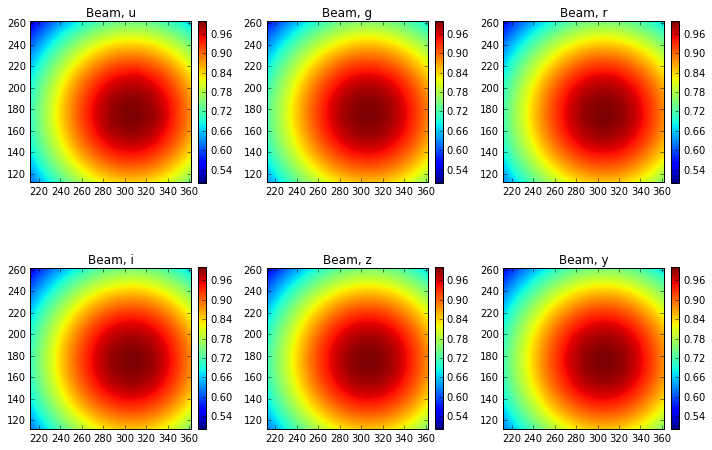

In [103]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
tmp = axes[0][0].imshow(recons['uv'], extent=extent, vmin=0.5, vmax=1)
axes[0][0].set_title('Beam, u')
plt.colorbar(tmp, ax=axes[0][0],fraction=0.046, pad=0.04)
tmp = axes[0][1].imshow(recons['blue'], extent=extent, vmin=0.5, vmax=1)
axes[0][1].set_title('Beam, g')
plt.colorbar(tmp, ax=axes[0][1],fraction=0.046, pad=0.04)
tmp = axes[0][2].imshow(recons['red'], extent=extent, vmin=0.5, vmax=1)
axes[0][2].set_title('Beam, r')
plt.colorbar(tmp, ax=axes[0][2],fraction=0.046, pad=0.04)
tmp = axes[1][0].imshow(recons['nm750'], extent=extent, vmin=0.5, vmax=1)
axes[1][0].set_title('Beam, i')
plt.colorbar(tmp, ax=axes[1][0],fraction=0.046, pad=0.04)
tmp = axes[1][1].imshow(recons['nm850'], extent=extent, vmin=0.5, vmax=1)
axes[1][1].set_title('Beam, z')
plt.colorbar(tmp, ax=axes[1][1],fraction=0.046, pad=0.04)
tmp = axes[1][2].imshow(recons['nm960'], extent=extent, vmin=0.5, vmax=1)
axes[1][2].set_title('Beam, y')
plt.colorbar(tmp, ax=axes[1][2],fraction=0.046, pad=0.04)
fig.tight_layout()

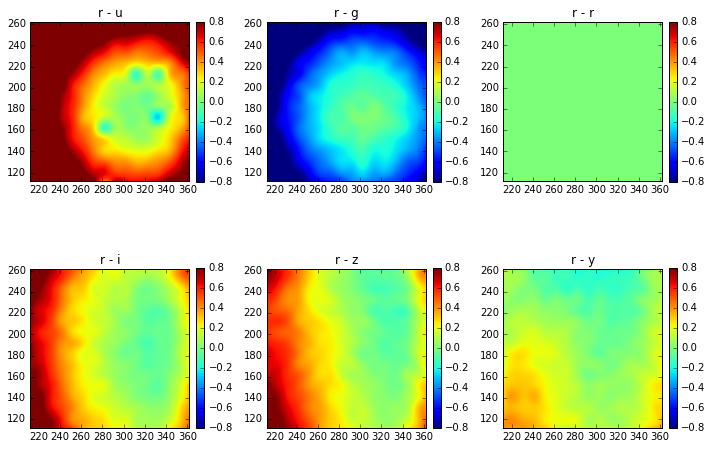

In [108]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
tmp = axes[0][0].imshow((recons['red']-recons['uv'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[0][0].set_title('r - u')
plt.colorbar(tmp, ax=axes[0][0],fraction=0.046, pad=0.04)
tmp = axes[0][1].imshow((recons['red']-recons['blue'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[0][1].set_title('r - g')
plt.colorbar(tmp, ax=axes[0][1],fraction=0.046, pad=0.04)
tmp = axes[0][2].imshow((recons['red']-recons['red'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[0][2].set_title('r - r')
plt.colorbar(tmp, ax=axes[0][2],fraction=0.046, pad=0.04)
tmp = axes[1][0].imshow((recons['red']-recons['nm750'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[1][0].set_title('r - i')
plt.colorbar(tmp, ax=axes[1][0],fraction=0.046, pad=0.04)
tmp = axes[1][1].imshow((recons['red']-recons['nm850'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[1][1].set_title('r - z')
plt.colorbar(tmp, ax=axes[1][1],fraction=0.046, pad=0.04)
tmp = axes[1][2].imshow((recons['red']-recons['nm960'])*1.e2/recons['red'], extent=extent, vmin=-0.8, vmax=0.8)
axes[1][2].set_title('r - y')
plt.colorbar(tmp, ax=axes[1][2],fraction=0.046, pad=0.04)
fig.tight_layout()

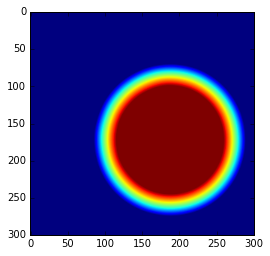

In [115]:
plt.imshow(recons['nm750'], vmin=0.9, vmax=0.95)

In [116]:
from astropy.table import Table

In [121]:
recons_table=Table(recons)

In [142]:
recons_table.write('beam_recons_image.fits')

In [126]:
import pyfits


In [127]:
d = pyfits.open('test_table.fits')

In [137]:
dd = d[1].data

In [141]:
dd['blue']

array([[ 0.56522165,  0.56682256,  0.56842274, ...,  0.67728884,
         0.67606803,  0.67483886],
       [ 0.56676492,  0.56836669,  0.56996821, ...,  0.67922456,
         0.6779969 ,  0.67676064],
       [ 0.56830393,  0.56990725,  0.57151074, ...,  0.68115913,
         0.6799246 ,  0.67868126],
       ..., 
       [ 0.63804825,  0.63996881,  0.64188434, ...,  0.76730181,
         0.76578855,  0.76426667],
       [ 0.6367785 ,  0.63869074,  0.64059827, ...,  0.76559213,
         0.76408338,  0.76256609],
       [ 0.63550566,  0.63740904,  0.63930806, ...,  0.76387544,
         0.76237104,  0.7608582 ]])